# Importing Libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Loading Dataset

In [3]:
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')

In [4]:
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
activities_map = {i:activities[i-1] for i in range(1, 7)}

In [5]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)
    

In [6]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(f"Shape of X_train = {x_train.shape}") 
print(f'Shape of y_train = {y_train.shape}')

x_test=np.array(x_test)
y_test=np.array(y_test)
print(f"Shape of X_test = {x_test.shape}")
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (126, 500, 3)
Shape of y_train = (126,)
Shape of X_test = (54, 500, 3)
Shape of y_test = (54,)


### Task 1 Question 1

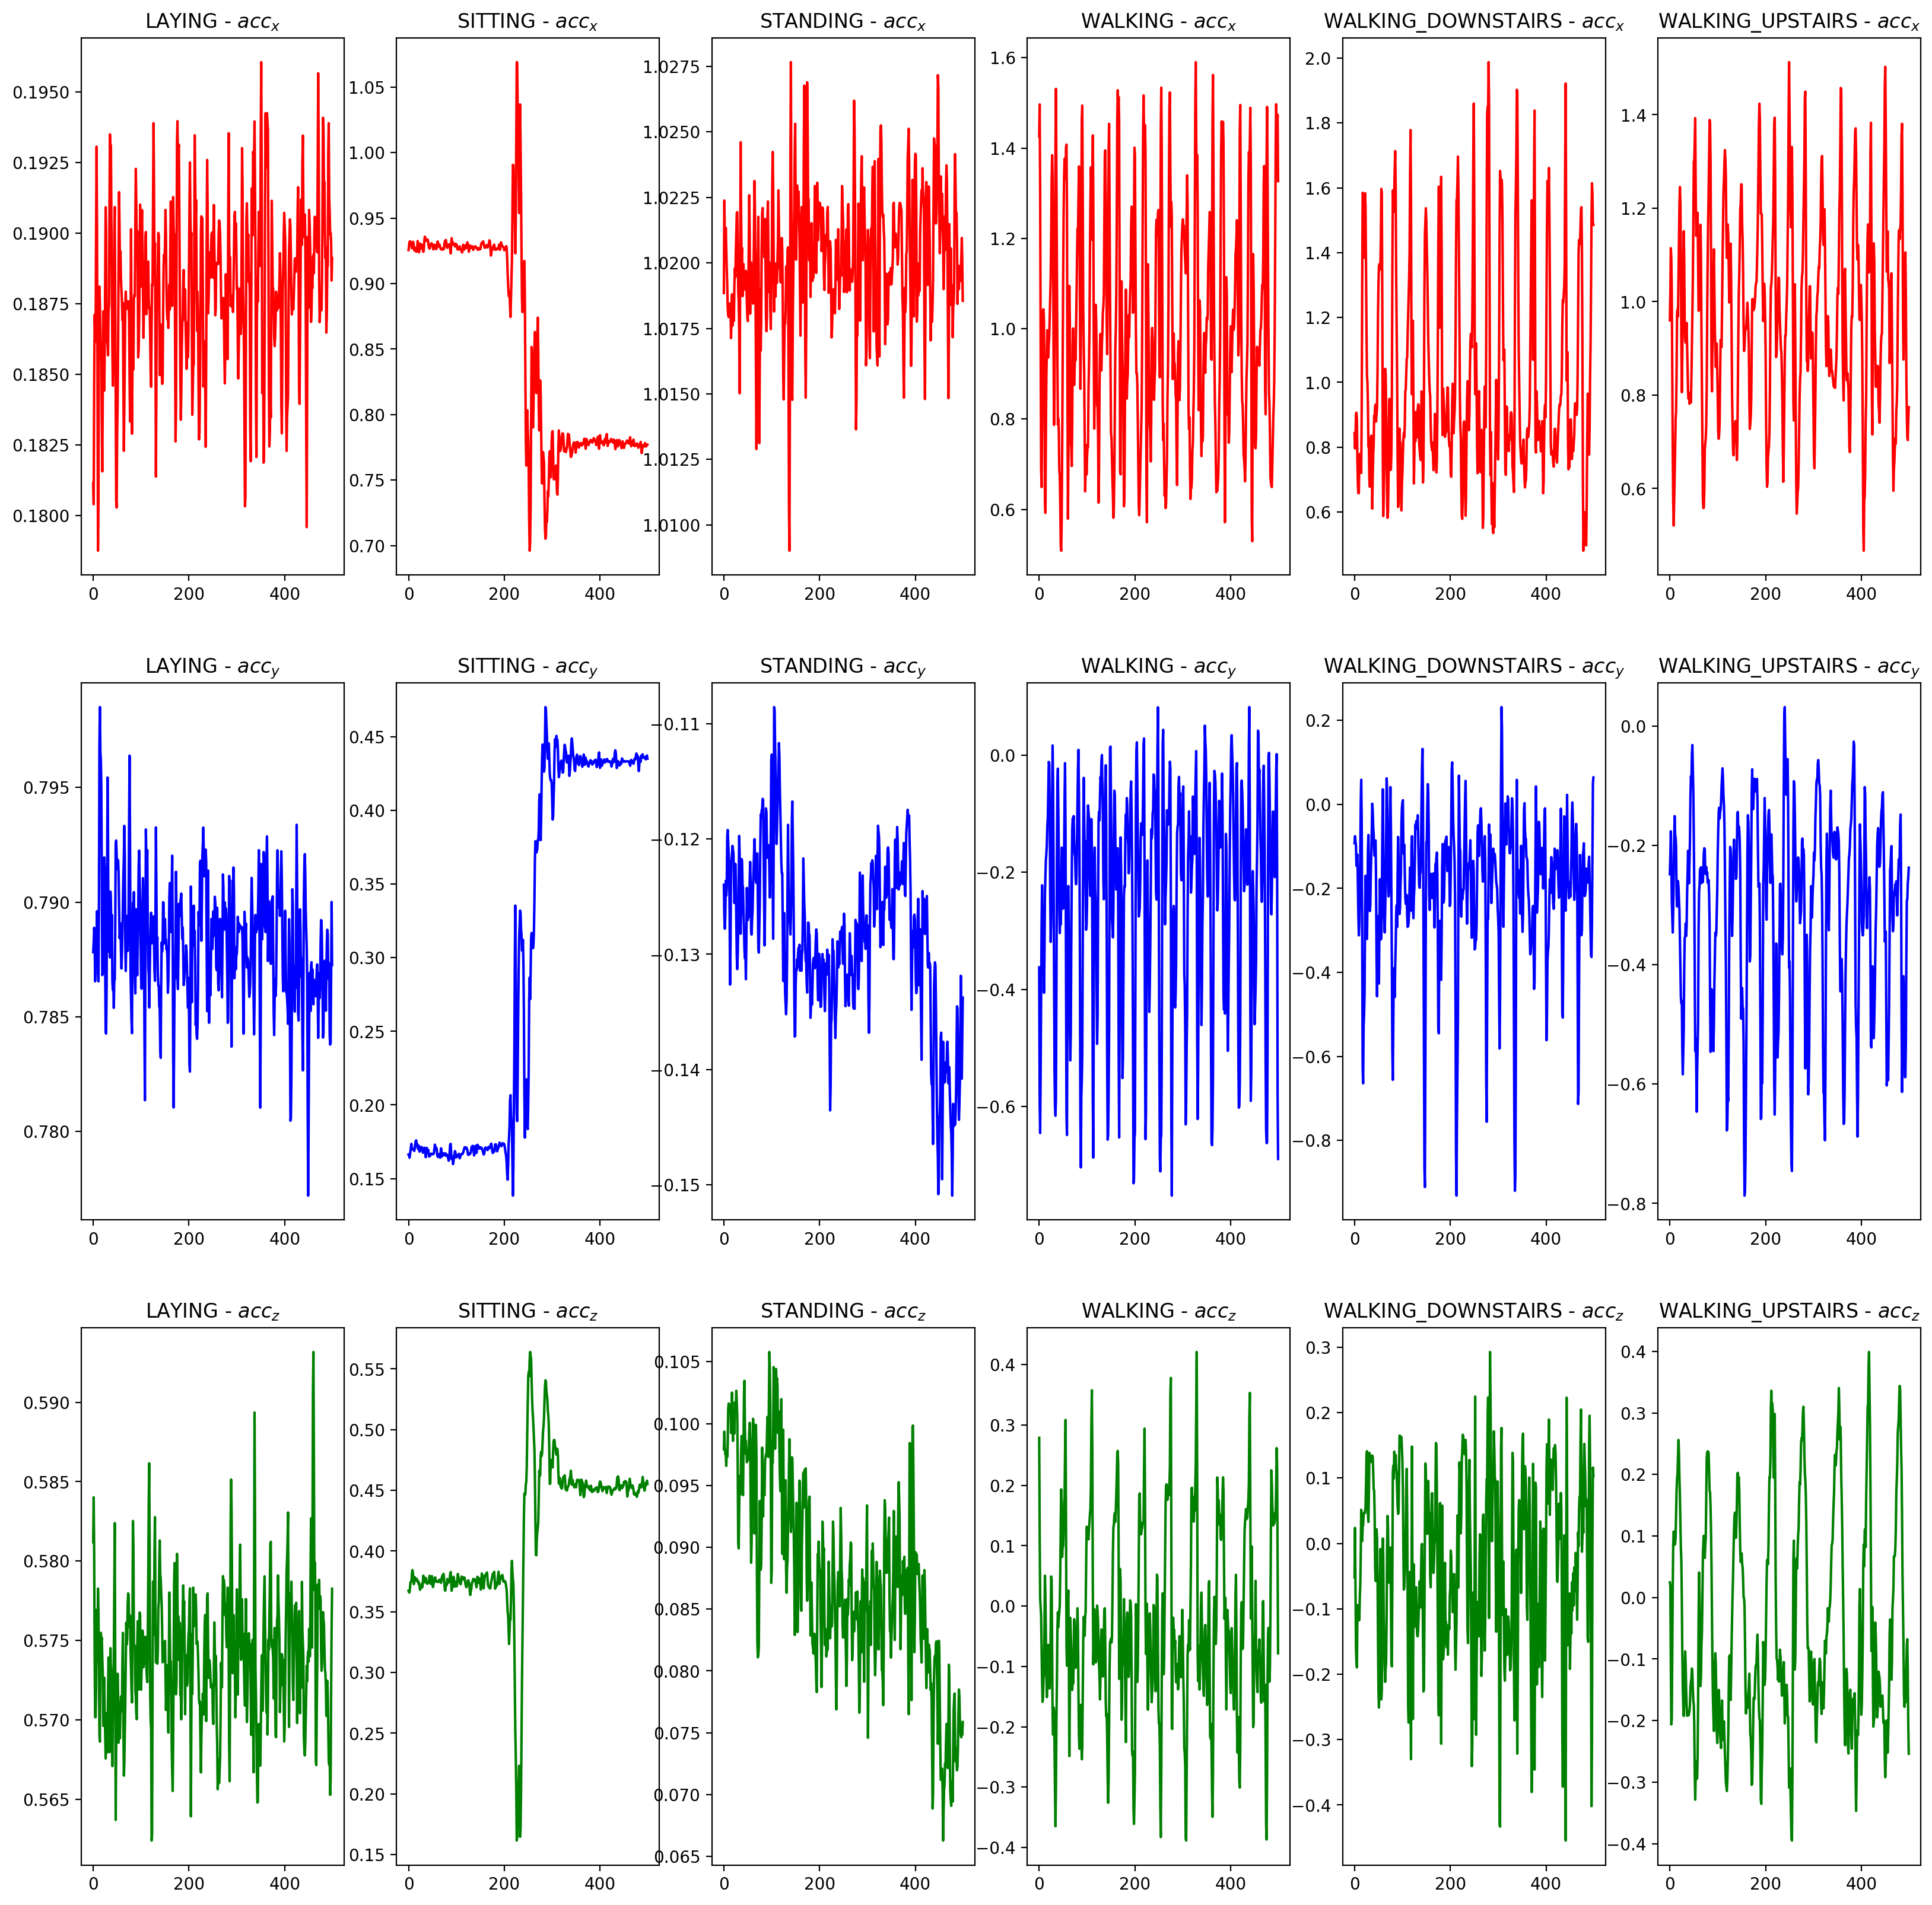

In [7]:
plt.figure(figsize=(20,20))
for i in range(6):
    activity = activities[i]
    data = x_train[i*21]
    acc_x = data[:,0]
    acc_y = data[:,1]
    acc_z = data[:,2]
    x = np.arange(0,500,1)
    plt.subplot(3,6,i+1)
    plt.plot(x,acc_x,c='r')
    plt.title(f"{activity} - $acc_x$")
    plt.subplot(3,6,i+7)
    plt.plot(x,acc_y,c='b')
    plt.title(f"{activity} - $acc_y$")
    plt.subplot(3,6,i+13)
    plt.plot(x,acc_z,c='g')
    plt.title(f"{activity} - $acc_z$")
plt.show()

The differences/similarities between the various activities are:
1. The variation in the accelerometer values of static acitivities like laying, sitting, and standing is much less than dynamic activities like walking, walking_upstairs and walking_downstairs.
2. The accelerometer readings are much different in the static activities (for example, acc x for laying is in the range (0.18,0.19), for sitting (0.7,1.05) and for standing (1.01,1.02) whereas its almost same for dynamic activities (0.6,1.5))

Yes, the model could classify the distinction between static and dynamic activities very clearly. Yet, it may face some difficulty in classifying among the different static and dynamic activities.

### Task 1, Question 2

In [8]:
total_acceleration = x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2
total_acceleration_x_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
for i in range(len(activities)):
    activity=activities[i]
    var_ = total_acceleration[i*21:(i+1)*21].var()
    mean_ = total_acceleration[i*21:(i+1)*21].mean()
    print(f"Mean total acceleration for activity {activity} = {mean_}")
    print(f"Variance in  total acceleration for activity {activity} = {var_}")

Mean total acceleration for activity LAYING = 1.0103142450756741
Variance in  total acceleration for activity LAYING = 0.00046204993741151107
Mean total acceleration for activity SITTING = 1.029346570214143
Variance in  total acceleration for activity SITTING = 0.0005658598040530853
Mean total acceleration for activity STANDING = 1.0650814326336357
Variance in  total acceleration for activity STANDING = 0.00027748397579156124
Mean total acceleration for activity WALKING = 1.1545508057464684
Variance in  total acceleration for activity WALKING = 0.25233633148708084
Mean total acceleration for activity WALKING_DOWNSTAIRS = 1.227920255515466
Variance in  total acceleration for activity WALKING_DOWNSTAIRS = 0.8607093928038053
Mean total acceleration for activity WALKING_UPSTAIRS = 1.1661549538347427
Variance in  total acceleration for activity WALKING_UPSTAIRS = 0.36599943016717296


No, we don't really need a machine learning model to distinguish between static and dynamic activities. We can classify them seperately just be setting some threshold on mean or variance or some other property as these numbers vary to a great extent between static and dynamic activities.

In [9]:
total_acceleration.shape

(126, 500)

In [10]:
total_acceleration_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
print(total_acceleration_test.shape)

(54, 500)


### Task 1, Question 3

#### PCA on Raw Data

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(total_acceleration)
pca_data = pca.transform(total_acceleration)
pca_data.shape


(126, 2)

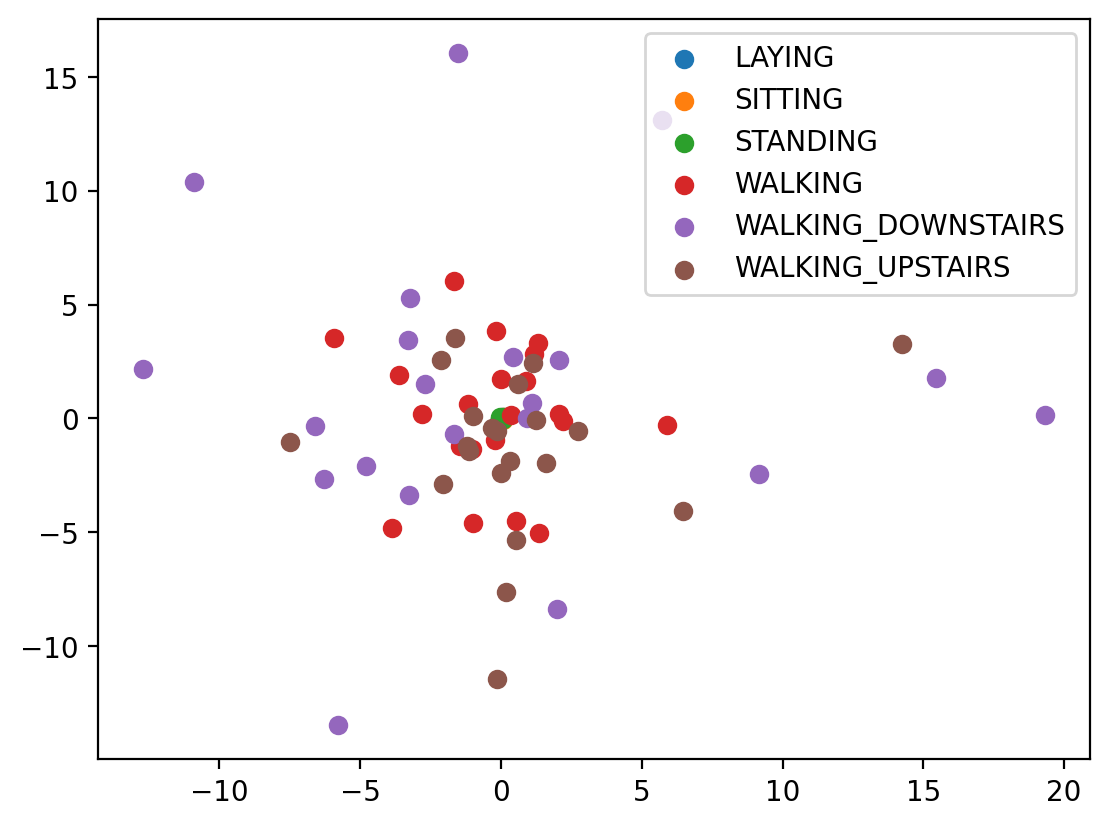

In [12]:

for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(pca_data[i*21:(i+1)*21,0],pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

#### Featurization using TSFEL

In [13]:
import tsfel
from tsfel.feature_extraction.features import calc_mean, calc_var, pk_pk_distance, mean_abs_deviation, auc, autocorr

In [14]:
def extract_features(data):
    tsfel_features=[]
    for i in range(len(data)):
        mean = calc_mean(data[i])
        var = calc_var(data[i])
        dist = pk_pk_distance(data[i])
        mad = mean_abs_deviation(data[i])
        corr = autocorr(data[i])
        auc_ = auc(data[i],50)
        tsfel_features.append([mean,var,dist,mad,corr,auc_])
    return tsfel_features


In [15]:
tsfel_features_train=np.array(extract_features(total_acceleration))
tsfel_features_test=np.array(extract_features(total_acceleration_test))

In [16]:
print(tsfel_features_train.shape)
print(tsfel_features_test.shape)

(126, 6)
(54, 6)


In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(tsfel_features_train)
tsfel_pca_data = pca.transform(tsfel_features_train)
tsfel_pca_data.shape

(126, 2)

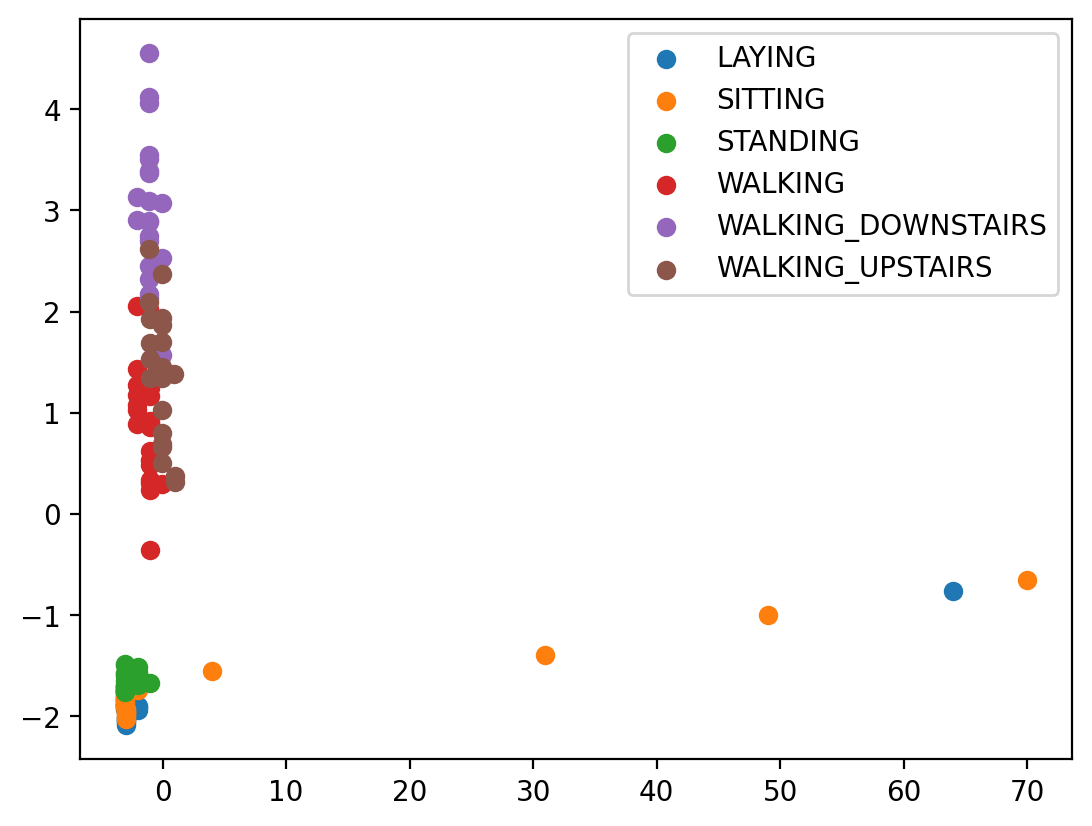

In [18]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(tsfel_pca_data[i*21:(i+1)*21,0],tsfel_pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

#### PCA on features provided in dataset

In [19]:
X_train_features = np.loadtxt('UCI HAR Dataset/train/X_train.txt')
X_train_features.shape

(7352, 561)

In [20]:
y_train_features = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
y_train_features.shape

(7352,)

In [21]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_features)
X_train_pca_data = pca.transform(X_train_features)
X_train_pca_data.shape

(7352, 2)

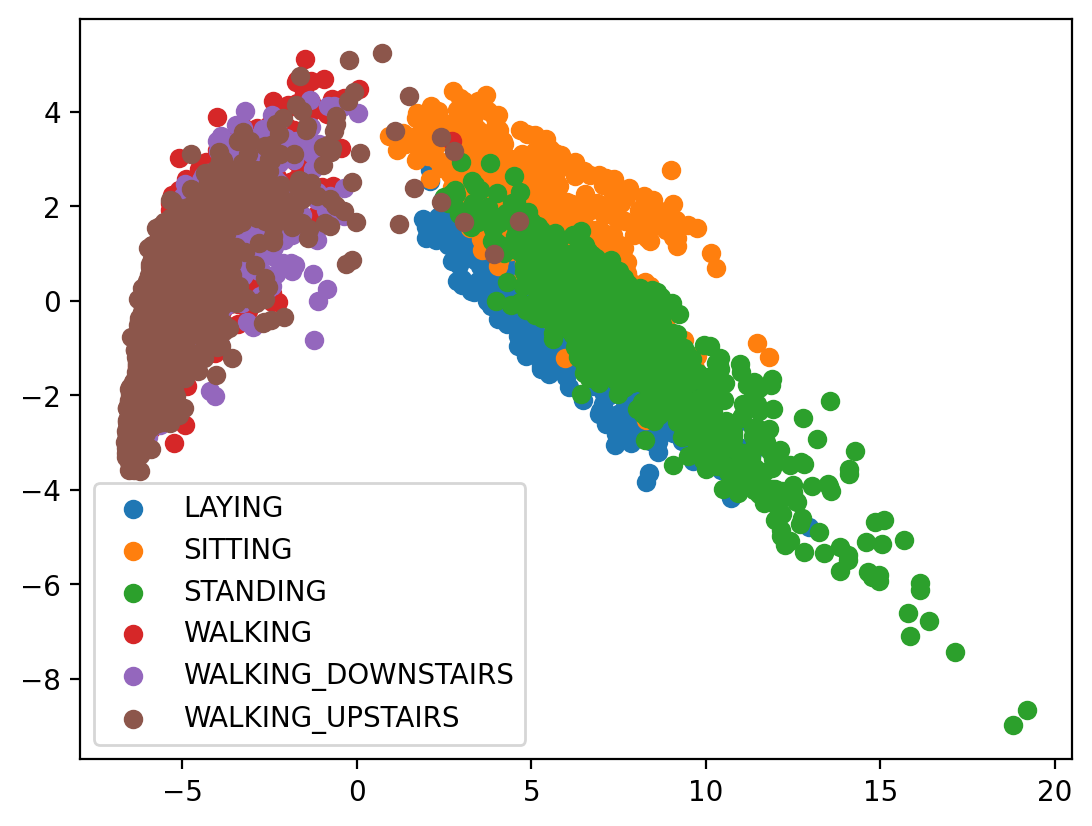

In [22]:
for i in range(1,7):
    plt.scatter(X_train_pca_data[y_train_features==i,0],X_train_pca_data[y_train_features==i,1],label=activities_map[i])
    plt.legend()
    

1. The PCA on the total_acceleration is very scattered and the different activities have very high overlapping region in that graph. 
2. Whereas, the PCA on TSFEL featurized data and on features provided in the data have better plots as different activities can be clearly distinguished in different clusters with less overlap.
3. Either of the TSFEL or dataset provided by the features is good for visualising the data.

### Task 1, Question 4

In [23]:
os.listdir()
features = np.loadtxt('UCI HAR Dataset/features.txt',dtype=str)
features = features[:, 1]

In [24]:
tsfel_features_train_df = pd.DataFrame(tsfel_features_train,columns=['mean','var','dist','mad','corr','auc'])
dataset_features_train_df = pd.DataFrame(X_train_features,columns=features)

Correlation matrix for TSFEL features

In [25]:
tsfel_features_train_df.corr()

,mean,var,dist,mad,corr,auc
mean,1.000000,0.906074,0.940925,0.963414,-0.091050,0.999958
var,0.906074,1.000000,0.908139,0.947084,-0.063738,0.906380
dist,0.940925,0.908139,1.000000,0.974450,-0.069124,0.941345
mad,0.963414,0.947084,0.974450,1.000000,-0.067565,0.963569
corr,-0.091050,-0.063738,-0.069124,-0.067565,1.000000,-0.091031
auc,0.999958,0.906380,0.941345,0.963569,-0.091031,1.000000


For TSFEL, all the features except the autocorrelation are highly correlated to each other. Autocorr is very less related to each of the others. <br>
Therefore, some of mean, var, dist, mad and auc are redundant here.

Correlation matrix for Dataset features

In [26]:
dataset_features_train_df.corr()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.030681,-0.017557,-0.015613,-0.544320,0.012173,0.037444,0.028844,-0.035257,0.034371,0.028242
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,-0.022395,-0.001587,-0.004459,0.070559,-0.013541,0.017967,0.075679,-0.005309,0.001053,-0.013903
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.020481,0.020091,0.019127,0.052841,-0.039836,-0.063609,-0.034037,0.008587,-0.015288,-0.022643
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.037444,0.017967,-0.063609,0.018985,-0.008507,-0.018429,0.019389,-0.012546,-0.023525,0.025066,...,-0.026615,0.034514,0.024553,-0.006269,0.009141,1.000000,-0.116001,-0.005853,-0.012313,-0.019903
"angle(tBodyGyroJerkMean,gravityMean)",0.028844,0.075679,-0.034037,-0.024810,-0.014592,-0.006471,-0.024951,-0.012341,-0.007231,-0.028871,...,0.000102,-0.017937,-0.014865,-0.020823,0.035263,-0.116001,1.000000,0.023995,-0.005869,-0.005656
"angle(X,gravityMean)",-0.035257,-0.005309,0.008587,-0.371653,-0.380531,-0.345011,-0.368191,-0.377025,-0.347389,-0.384192,...,0.087332,-0.086006,-0.079751,0.011880,0.023246,-0.005853,0.023995,1.000000,-0.783848,-0.643655
"angle(Y,gravityMean)",0.034371,0.001053,-0.015288,0.471065,0.523600,0.476006,0.466424,0.525081,0.477607,0.480229,...,-0.100125,0.086993,0.078079,0.001540,-0.012990,-0.012313,-0.005869,-0.783848,1.000000,0.594885


### Task 2, Question 1

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

#### Raw Data Tree

Accuracy = 0.46296296296296297
Precision = 0.46991896991896986
Recall = 0.46296296296296297
F1 Score = 0.4404401154401154


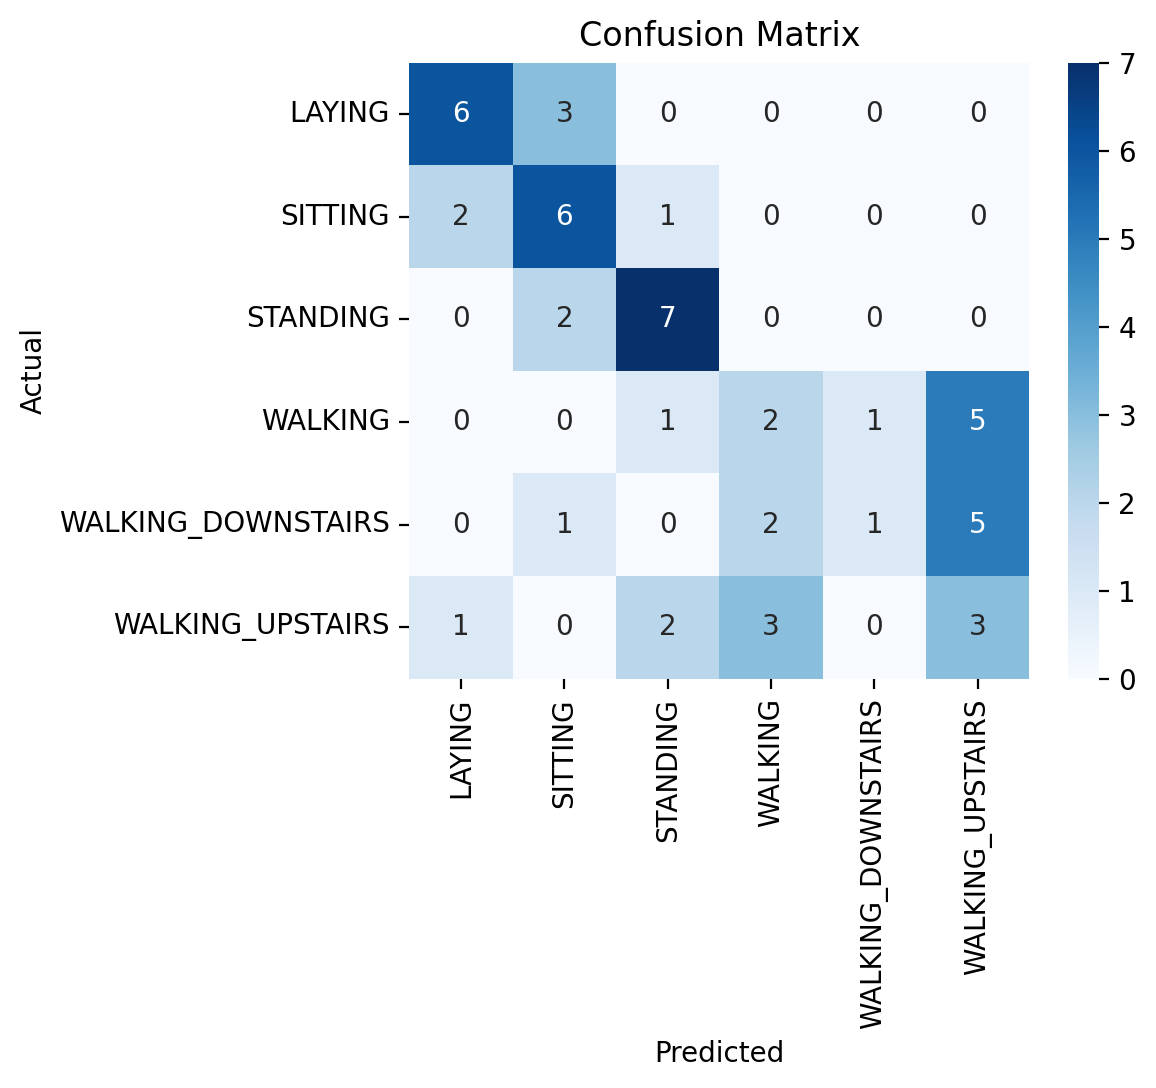

In [28]:
raw_data_tree = DecisionTreeClassifier()
raw_data_tree.fit(total_acceleration,y_train)
y_pred = raw_data_tree.predict(total_acceleration_test)
print(f"Accuracy = {accuracy_score(y_test,y_pred)}")
print(f"Precision = {precision_score(y_test,y_pred,average='weighted')}")
print(f"Recall = {recall_score(y_test,y_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y_test,y_pred,average='weighted')}")
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### TSFEL Tree

Accuracy = 0.7407407407407407
Precision = 0.747174122174122
Recall = 0.7407407407407407
F1 Score = 0.7393246187363836


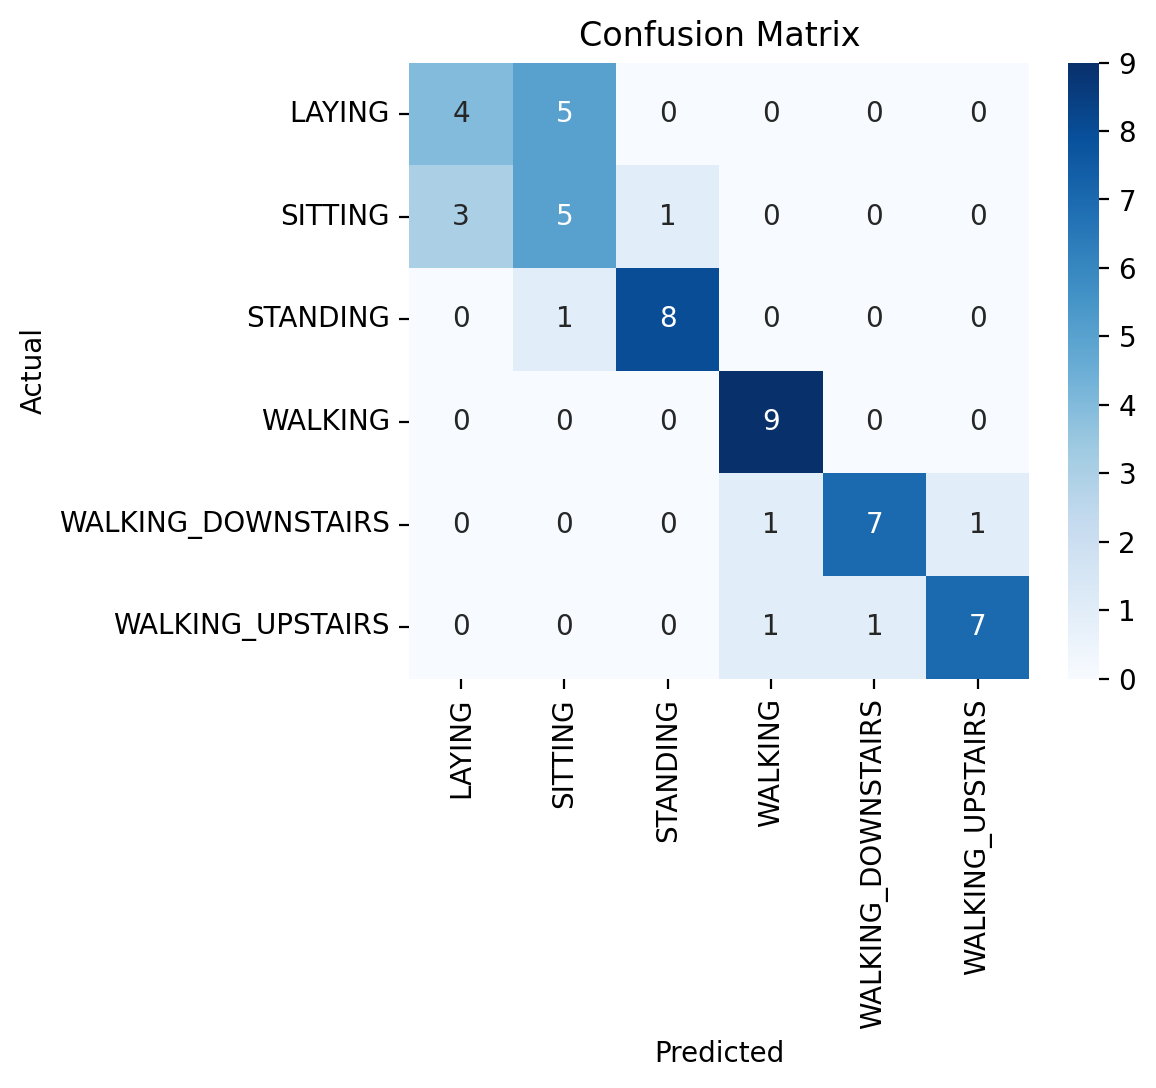

In [29]:
tsfel_tree = DecisionTreeClassifier()
tsfel_tree.fit(tsfel_features_train,y_train)
y_pred = tsfel_tree.predict(tsfel_features_test)
print(f"Accuracy = {accuracy_score(y_test,y_pred)}")
print(f"Precision = {precision_score(y_test,y_pred,average='weighted')}")
print(f"Recall = {recall_score(y_test,y_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y_test,y_pred,average='weighted')}")
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Dataset features tree

In [30]:
X_test_features = np.loadtxt('UCI HAR Dataset/test/X_test.txt')
X_test_features.shape

(2947, 561)

In [31]:
y_test_features = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
y_test_features.shape

(2947,)

Accuracy = 0.8710553104852392
Precision = 0.8721548046032969
Recall = 0.8710553104852392
F1 Score = 0.8704969139665574


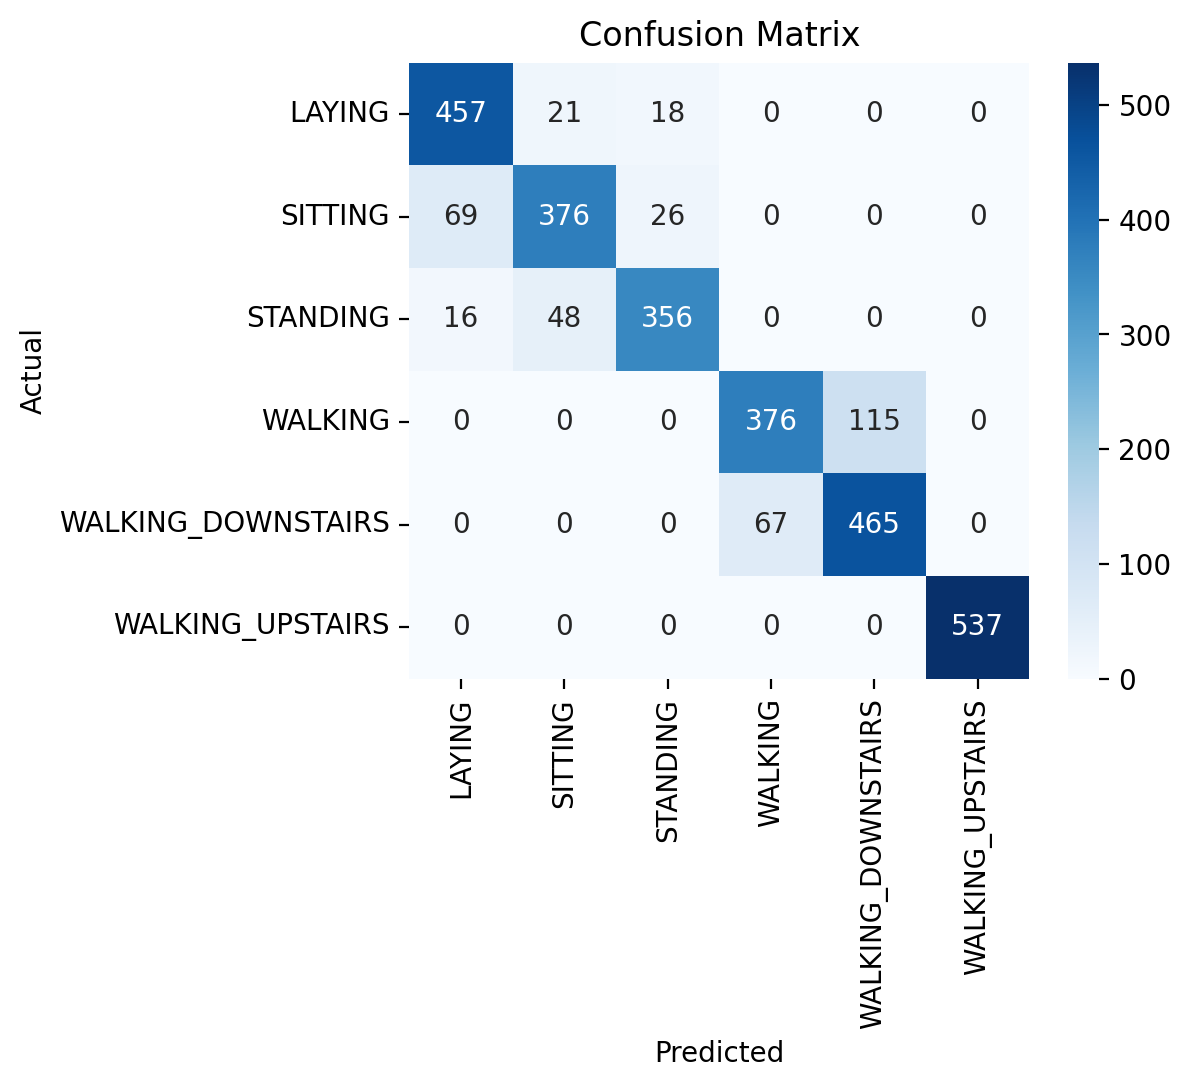

In [32]:
features_tree = DecisionTreeClassifier()
features_tree.fit(X_train_features,y_train_features)
y_pred = features_tree.predict(X_test_features)
print(f"Accuracy = {accuracy_score(y_test_features,y_pred)}")
print(f"Precision = {precision_score(y_test_features,y_pred,average='weighted')}")
print(f"Recall = {recall_score(y_test_features,y_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y_test_features,y_pred,average='weighted')}")
cm = confusion_matrix(y_test_features,y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The accuracies of the three models are:
1. Raw data: 51.85 %
2. TSFEL data: 81.48%
3. Features in the dataset: 86.25 %
<br>
Therefore, the best model with respect to accuracy score is the model trained on features provided by the dataset.

### Task 2, Question 2

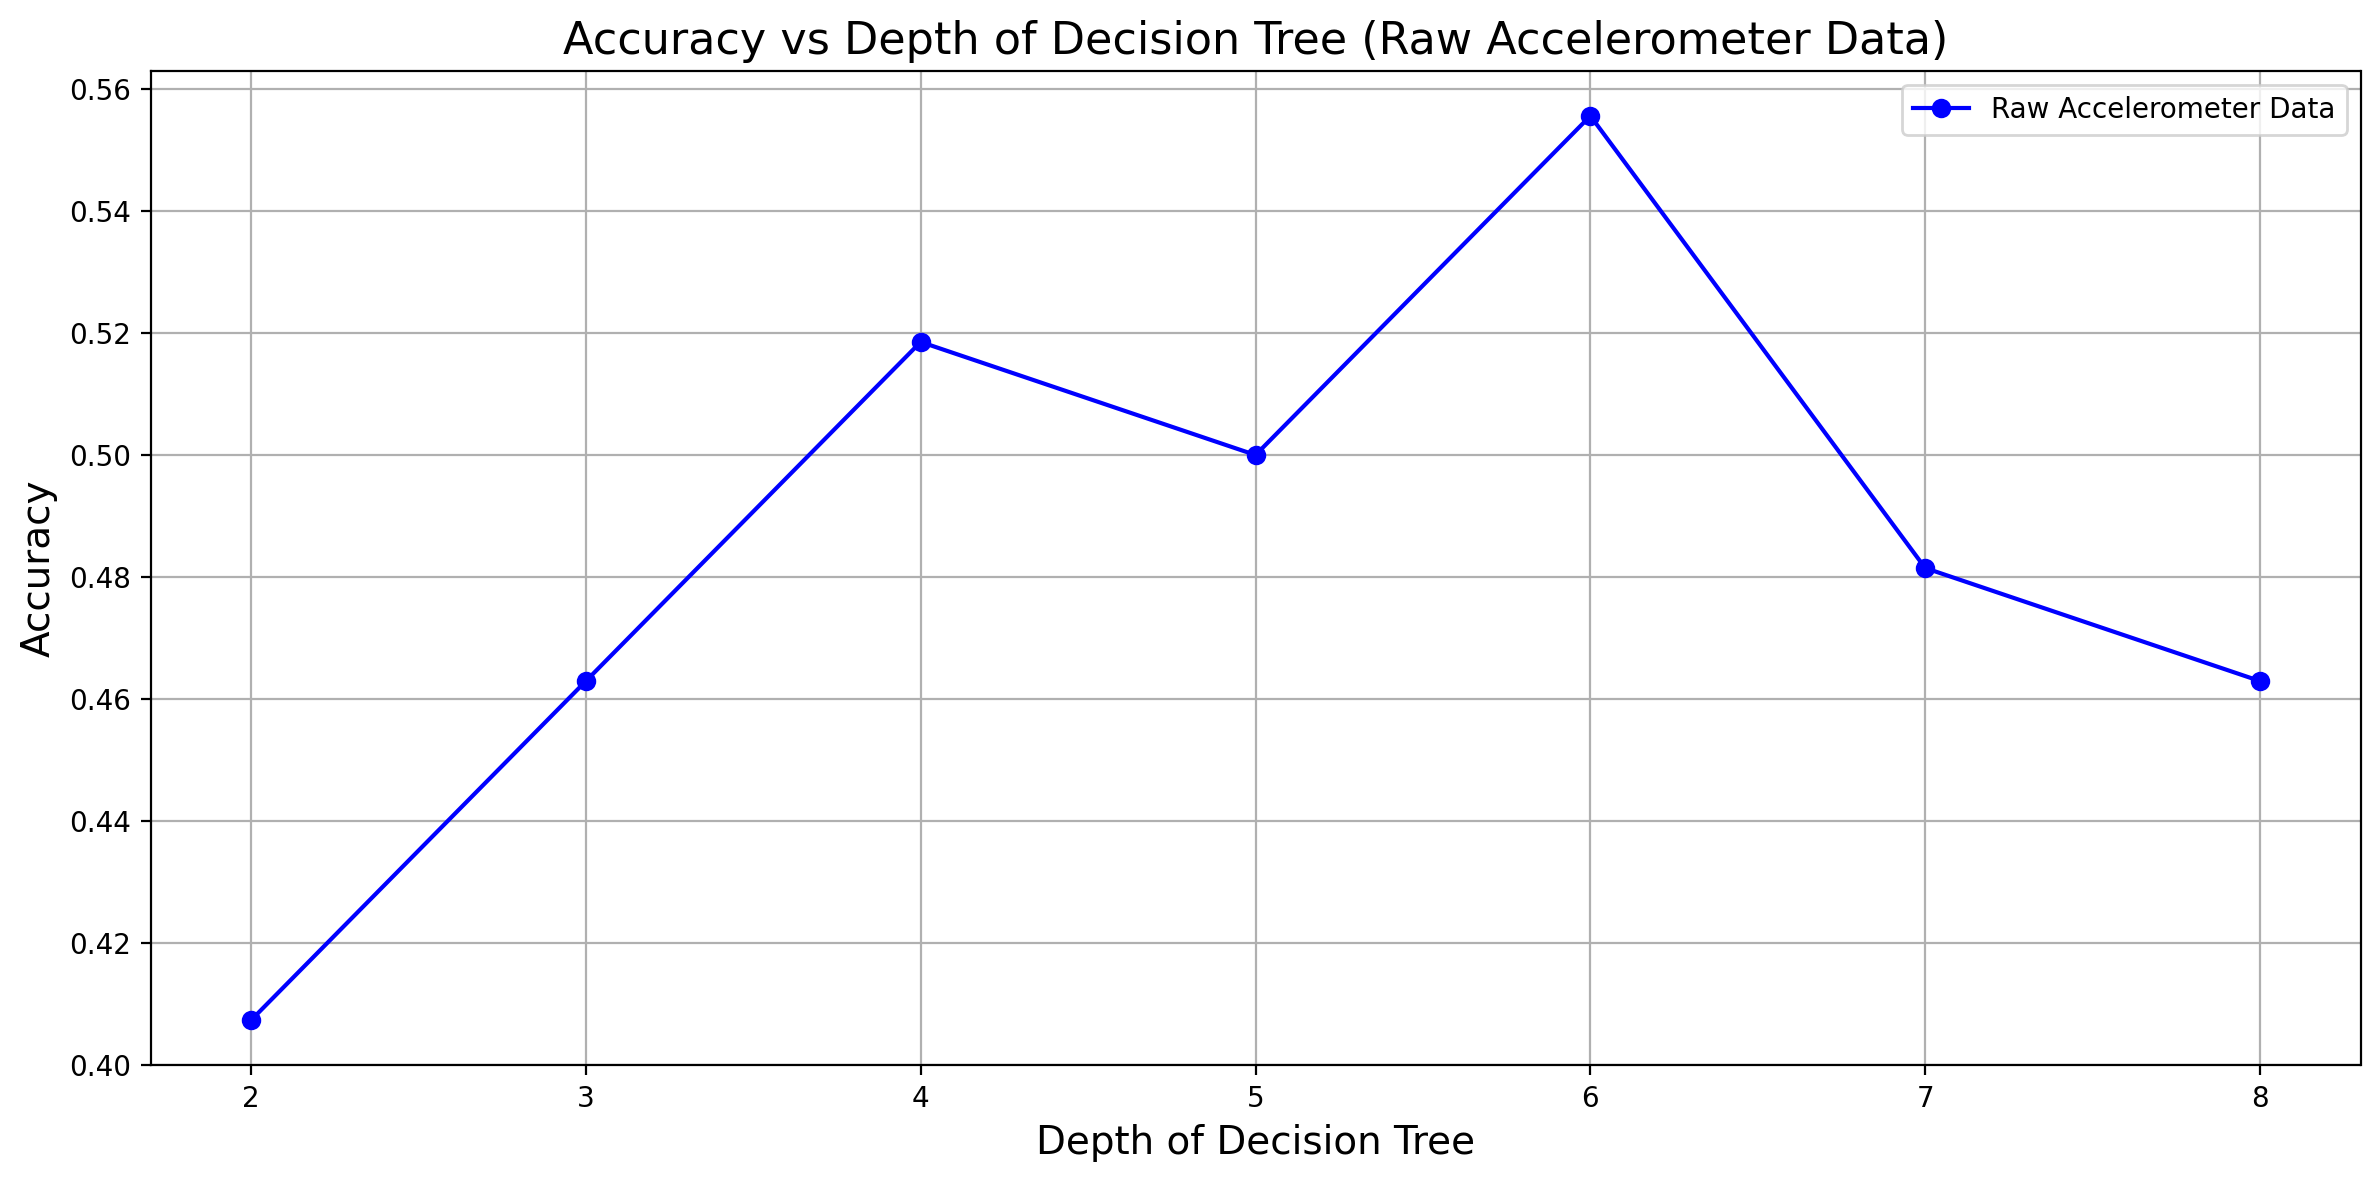

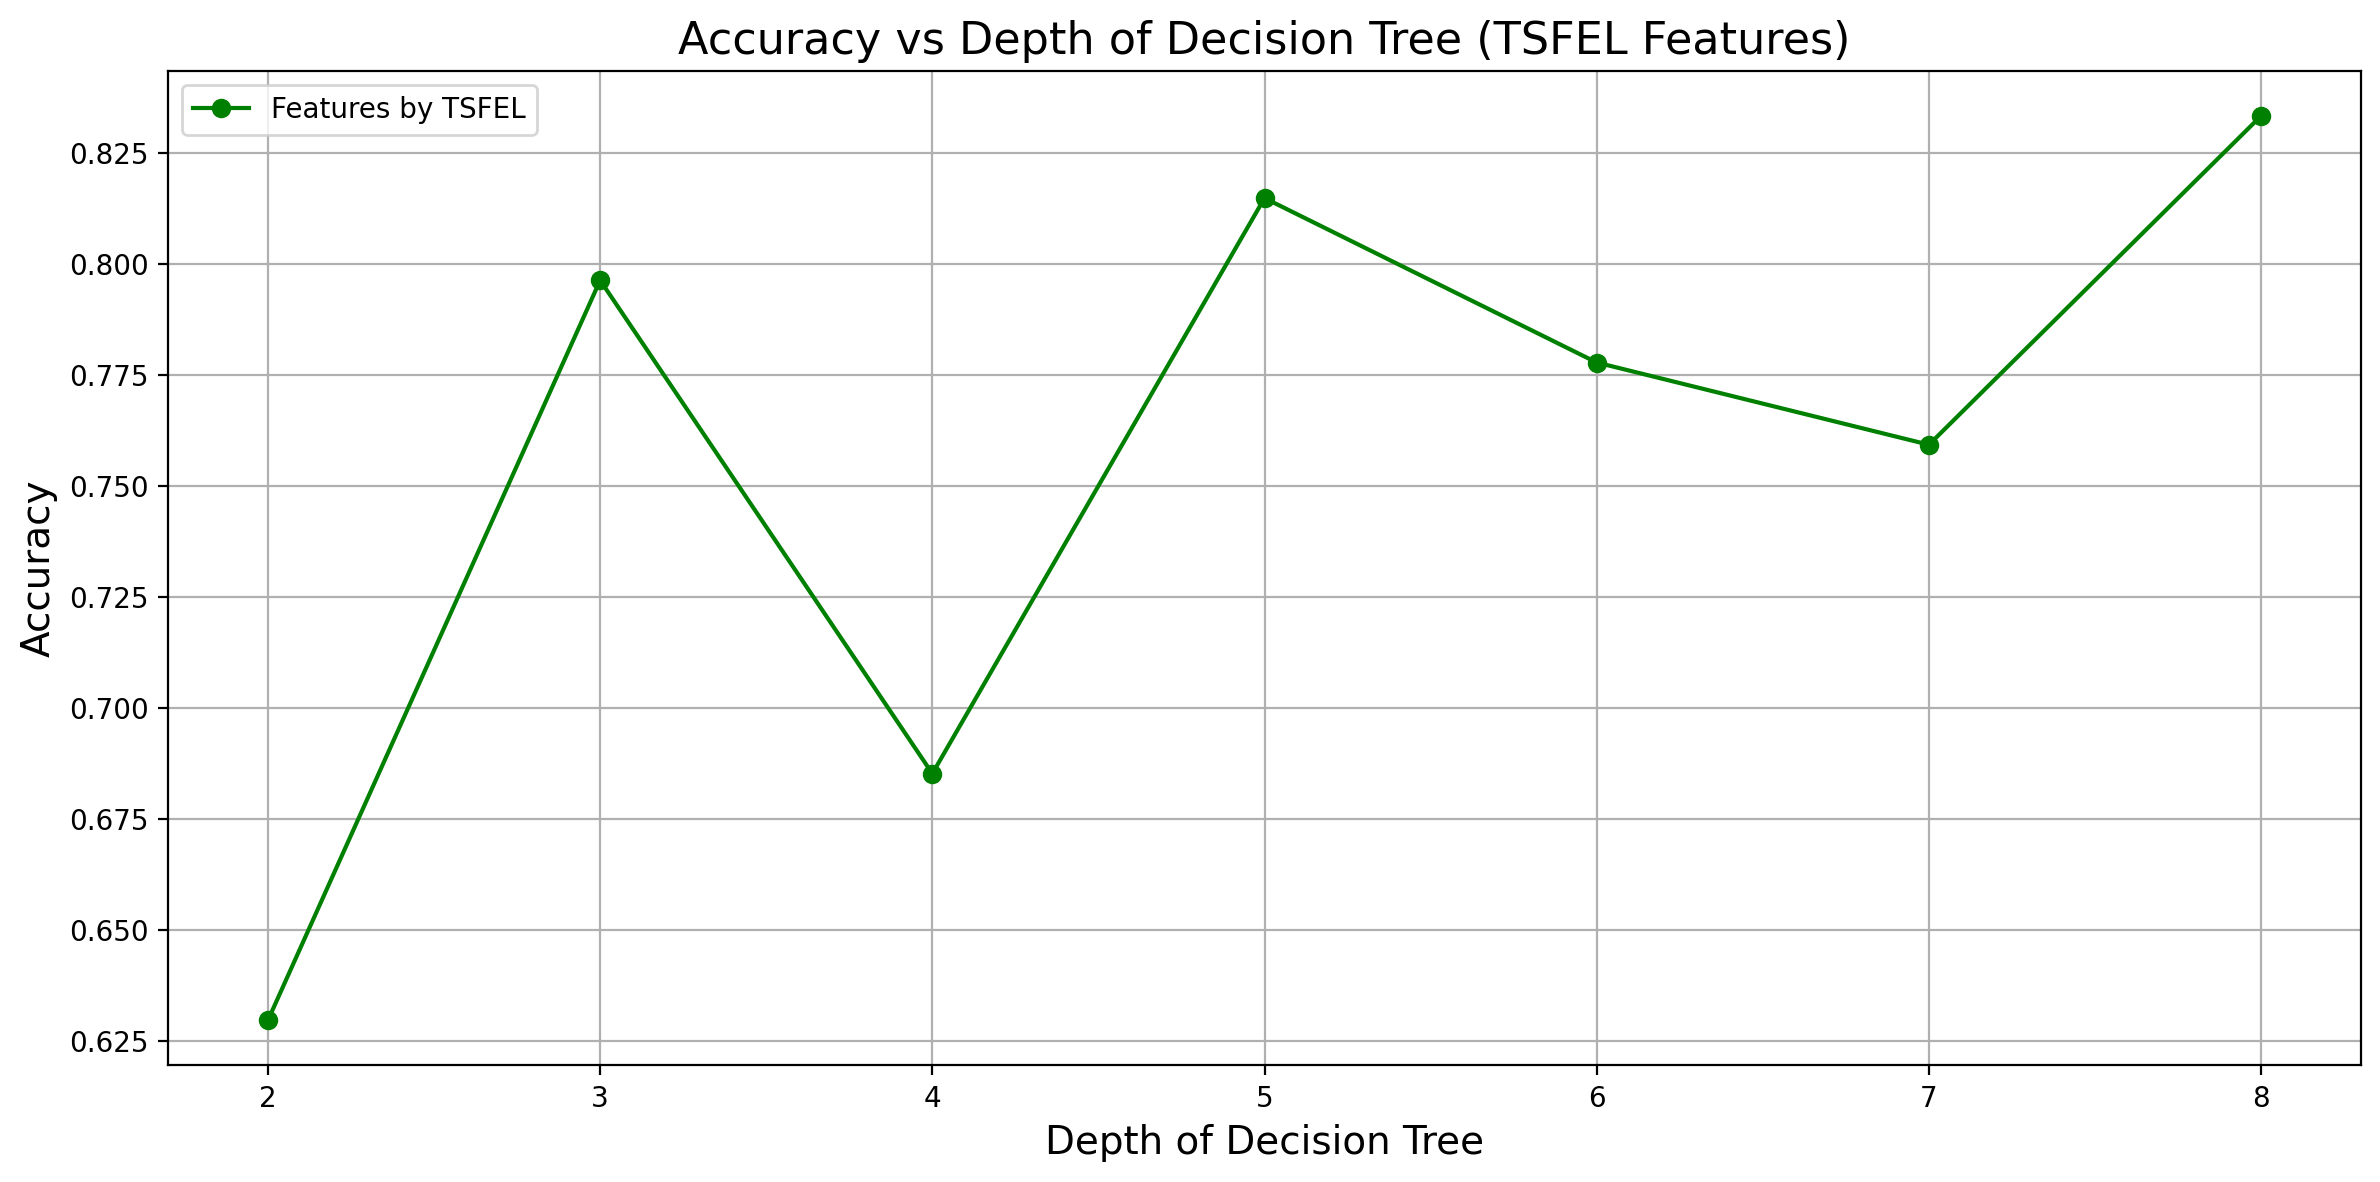

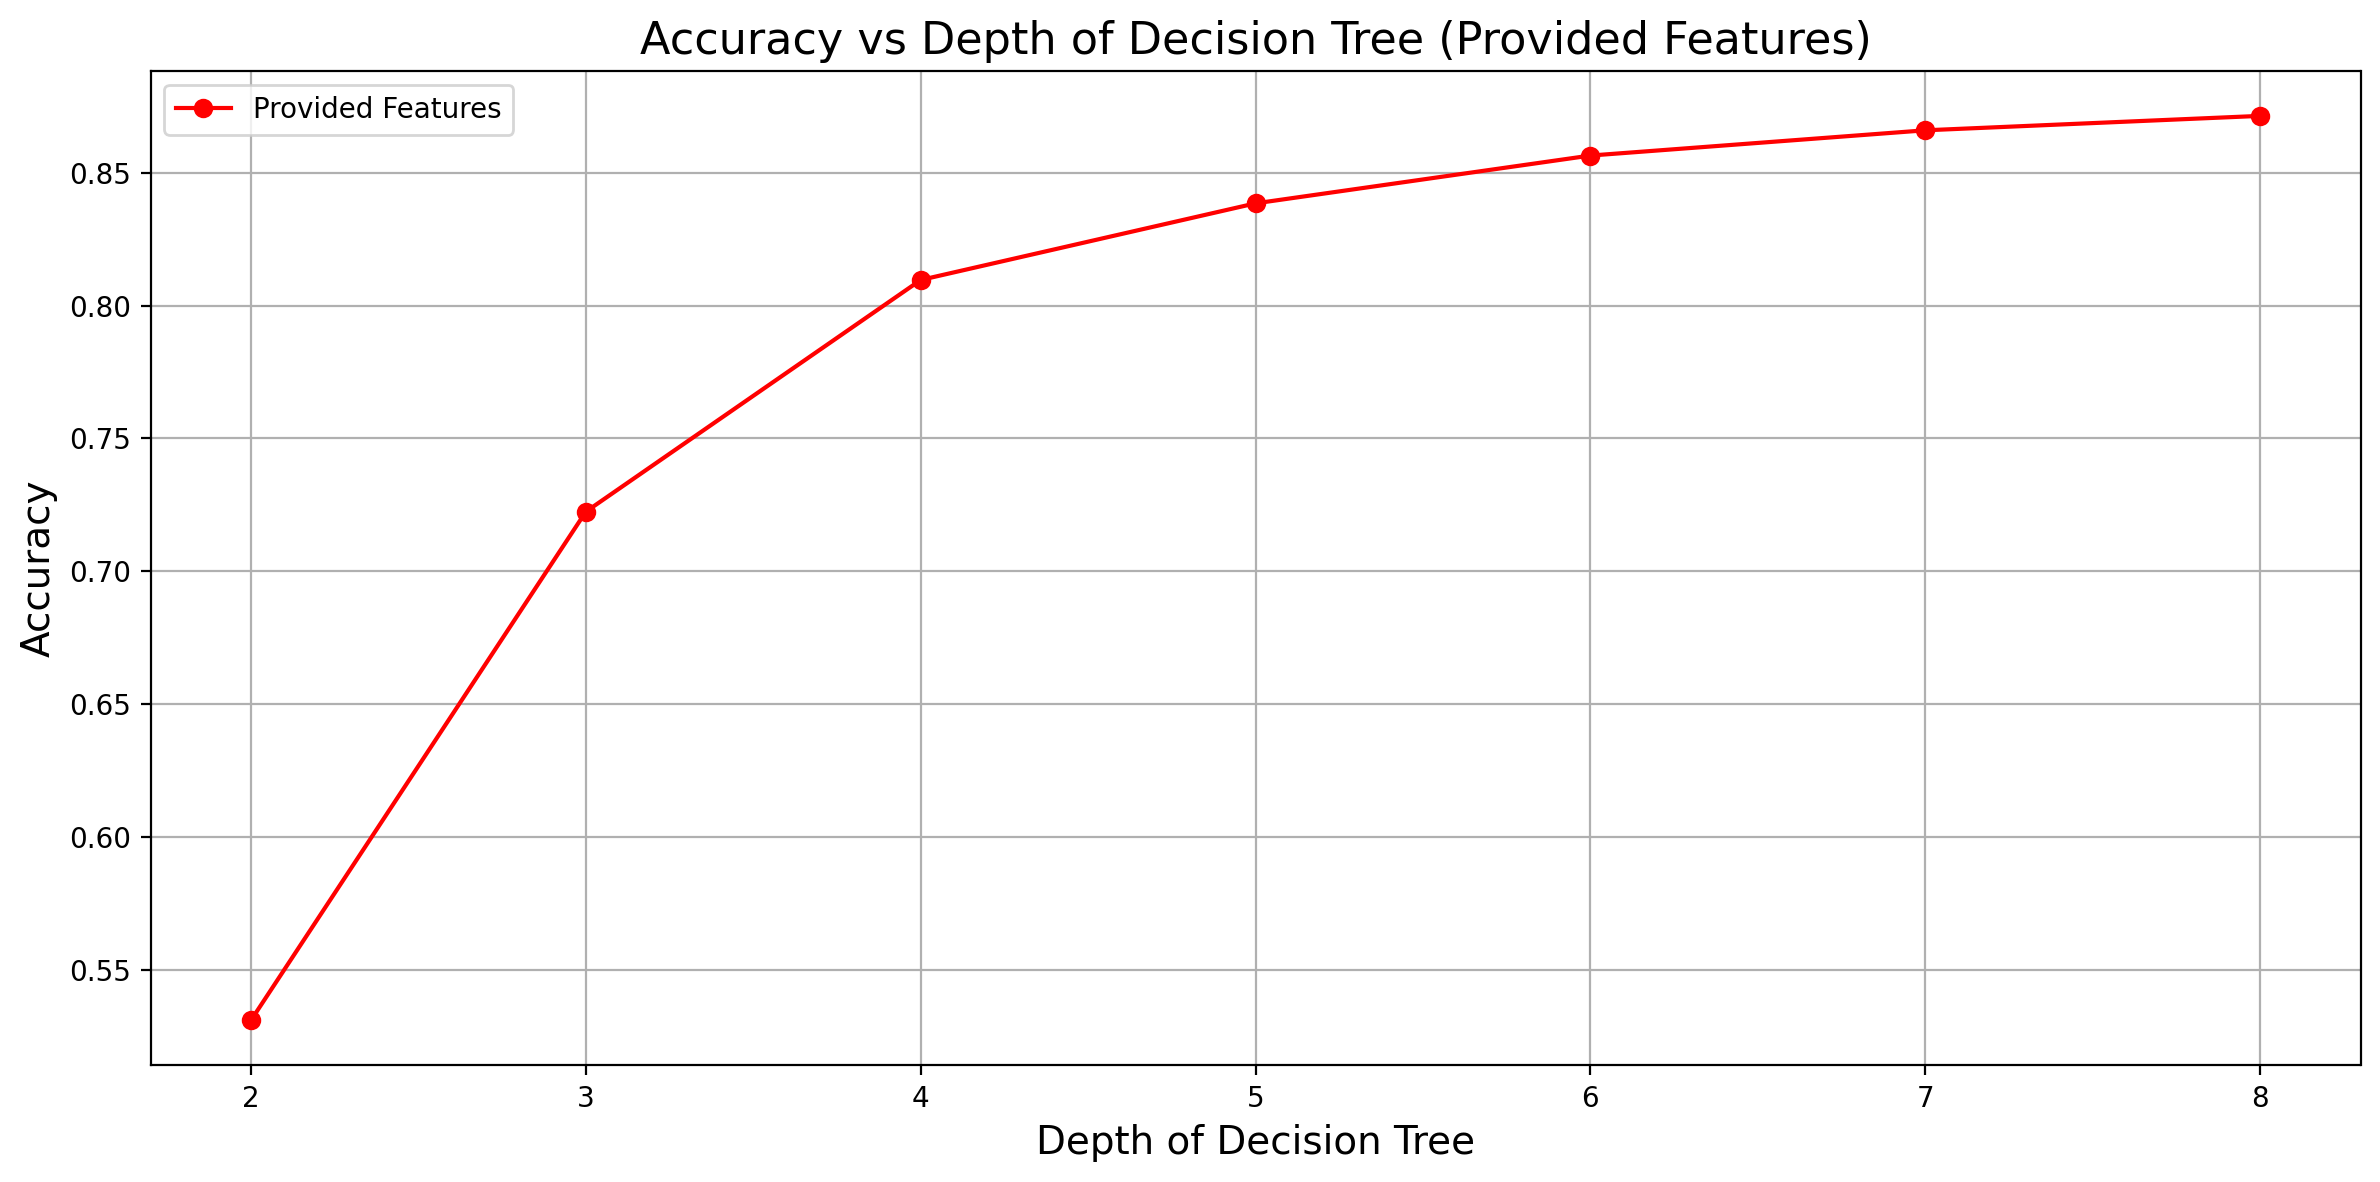

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depths = range(2, 9)
accuracies_raw = []
accuracies_tsfel = []
accuracies_features = []


# Train and evaluate Decision Tree with raw accelerometer data
for depth in depths:
    raw_tree = DecisionTreeClassifier(max_depth=depth)
    raw_tree.fit(total_acceleration, y_train)

    y_predict_raw = raw_tree.predict(total_acceleration_x_test)
    accuracies_raw.append(accuracy_score(y_test, y_predict_raw))

# Plot accuracy vs depth for raw accelerometer data
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_raw, marker='o', linestyle='-', color='b', label='Raw Accelerometer Data')
plt.xlabel('Depth of Decision Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Depth of Decision Tree (Raw Accelerometer Data)', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train and evaluate Decision Tree with TSFEL features
for depth in depths:
    tsfel_tree = DecisionTreeClassifier(max_depth=depth)
    tsfel_tree.fit(tsfel_features_train, y_train)

    y_predict_tsfel = tsfel_tree.predict(tsfel_features_test)
    accuracies_tsfel.append(accuracy_score(y_test, y_predict_tsfel))

# Plot accuracy vs depth for features obtained by TSFEL
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_tsfel, marker='o', linestyle='-', color='g', label='Features by TSFEL')
plt.xlabel('Depth of Decision Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Depth of Decision Tree (TSFEL Features)', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train and evaluate Decision Tree with provided features
for depth in depths:
    features_tree = DecisionTreeClassifier(max_depth=depth)
    features_tree.fit(X_train_features,y_train_features)

    y_predict_features = features_tree.predict(X_test_features)
    accuracies_features.append(accuracy_score(y_test_features, y_predict_features))

# Plot accuracy vs depth for provided features
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_features, marker='o', linestyle='-', color='r', label='Provided Features')
plt.xlabel('Depth of Decision Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Depth of Decision Tree (Provided Features)', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Task 2, Question 3

#### There isn't any specific activity where the model pereforms bad. 
However, it is seen from the confusion matrices, that the model is able to distinguish static from dynamic activities. However, the model is misclalssifying sometimes between walking, walking_upstairs and walking_downstairs, and between laying, sitting and standing.

### Task 4, Question 1

In [34]:
recorded_folder_path = os.path.join('./Activity Dataset/')
csv_files = os.listdir(recorded_folder_path)
X_train = []
X_total_acceleration = []
y = ["LAYING", "SITTING", "STANDING",  "WALKIING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"] * 3

for csv in csv_files:
    df=pd.read_csv(os.path.join(recorded_folder_path, csv),header=0)
    X_train.append(df.values[300:800][:, 1:4])
    X_total_acceleration.append(df.values[300:800][:, 4])

In [35]:
recorded_data_prediction = raw_data_tree.predict(X_total_acceleration)
recorded_data_prediction

array(['SITTING', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'STANDING',
       'STANDING', 'STANDING', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS',
       'WALKING_UPSTAIRS', 'STANDING', 'STANDING', 'WALKING_UPSTAIRS',
       'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS',
       'STANDING', 'STANDING', 'STANDING'], dtype='<U18')

Accuracy = 0.05555555555555555
Precision = 0.018518518518518517
Recall = 0.05555555555555555
F1 Score = 0.027777777777777776


e:\ES 335 -  Machine Learning\es335-24-fall-assignment-1-master\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


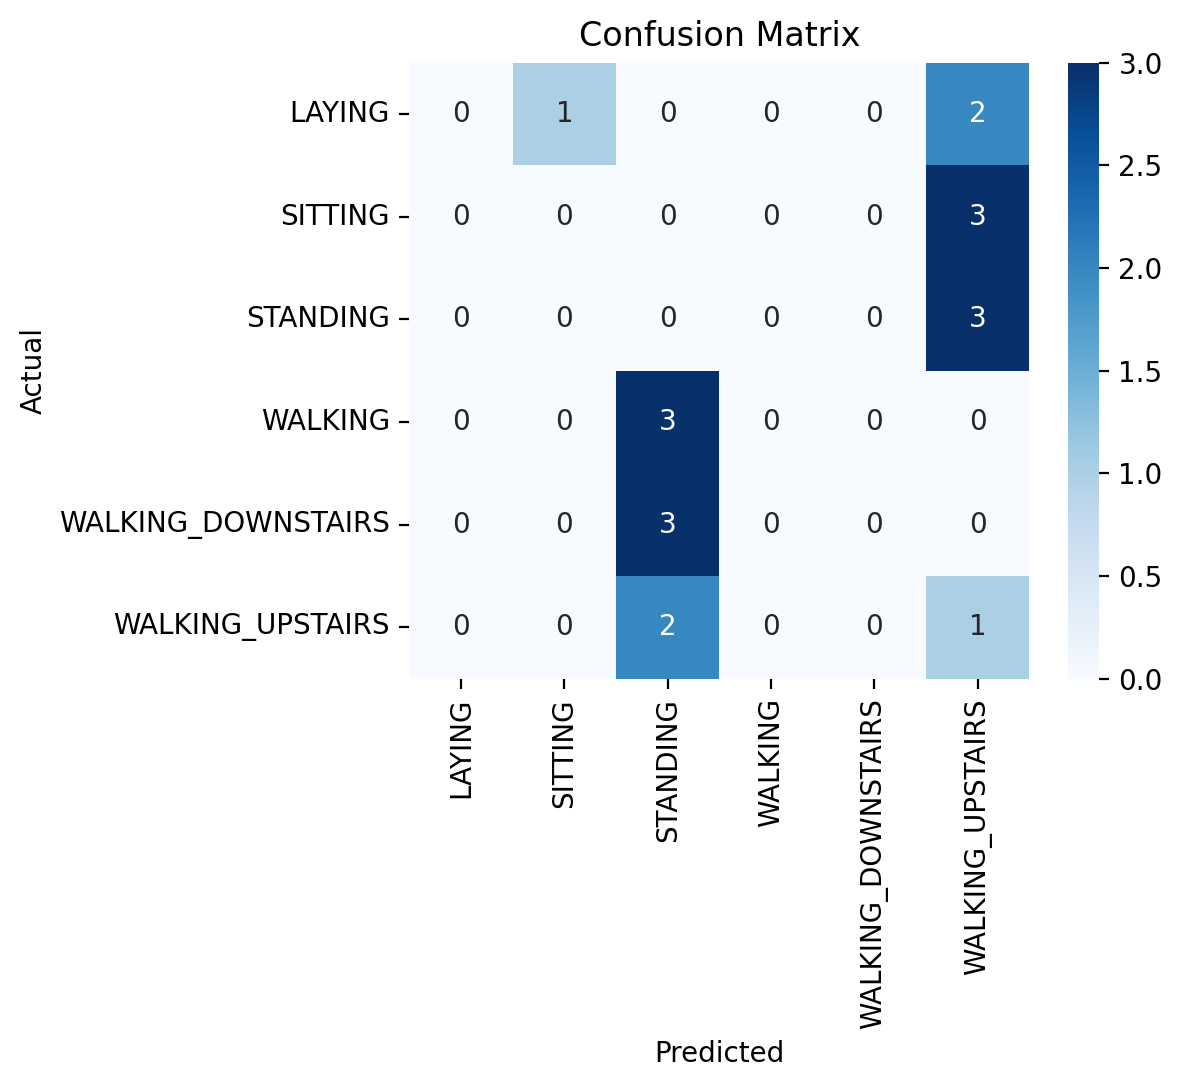

In [36]:
print(f"Accuracy = {accuracy_score(y,recorded_data_prediction)}")
print(f"Precision = {precision_score(y,recorded_data_prediction,average='weighted')}")
print(f"Recall = {recall_score(y,recorded_data_prediction,average='weighted')}")
print(f"F1 Score = {f1_score(y,recorded_data_prediction,average='weighted')}")
cm = confusion_matrix(y,recorded_data_prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy = 0.2777777777777778
Precision = 0.1111111111111111
Recall = 0.2777777777777778
F1 Score = 0.15740740740740738


e:\ES 335 -  Machine Learning\es335-24-fall-assignment-1-master\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\ES 335 -  Machine Learning\es335-24-fall-assignment-1-master\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


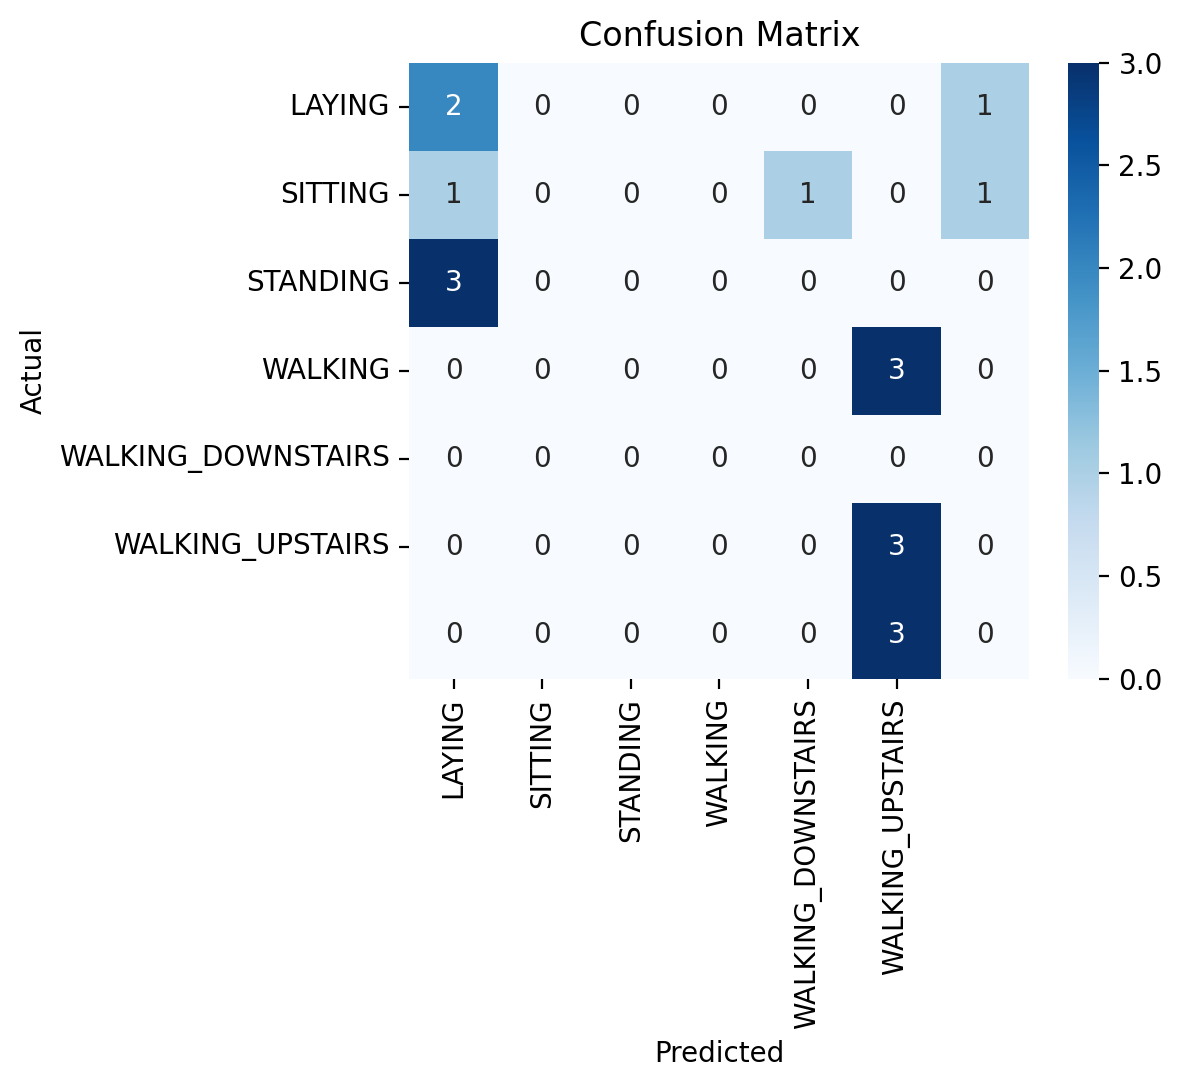

In [37]:
recorded_tsfel_features = extract_features(X_total_acceleration)
recorded_tsfel_prediction = tsfel_tree.predict(recorded_tsfel_features)
print(f"Accuracy = {accuracy_score(y,recorded_tsfel_prediction)}")
print(f"Precision = {precision_score(y,recorded_tsfel_prediction,average='weighted')}")
print(f"Recall = {recall_score(y,recorded_tsfel_prediction,average='weighted')}")
print(f"F1 Score = {f1_score(y,recorded_tsfel_prediction,average='weighted')}")
cm = confusion_matrix(y,recorded_tsfel_prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### The Decision tree was already trained in the previous tasks and now it is tested on the actual recorded data. The TSFEL featuried data gave more accuracy, precision, recall as well as F1 score than the raw data.

In [38]:
recorded_data_model = DecisionTreeClassifier()
recorded_data_model.fit(X_total_acceleration[:15], y[:15])
prediction = recorded_data_model.predict(X_total_acceleration[15:])
prediction

array(['WALKIING', 'WALKIING', 'WALKING_DOWNSTAIRS'], dtype='<U18')

In [40]:
recorded_tsfel_model = DecisionTreeClassifier()
recorded_tsfel_model.fit(recorded_tsfel_features[:15], y[:15])
prediction = recorded_tsfel_model.predict(recorded_tsfel_features[15:])


In [42]:
prediction

array(['WALKING_DOWNSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING_DOWNSTAIRS'],
      dtype='<U18')

##### For prediction of the raw data the predictade value are not correct, While the the prediction done using the TSFEL featureised data it prdicted the one sample data namely 'WALKING_DOWNSTAIRS' correctly.